This notebook provides codes for generating all plots for stroke impairment assessment using COBRA scores calculated from wearable sensor input. It takes saved COBRA score and produces plots in **Quantifying Impairment and Disease Severity Using AI Models Trained on Healthy Subjects** by Boyang Yu*, Aakash Kaku*, Kangning Liu*, Avinash Parnandi, Emily Fokas, Anita Venkatesan, Natasha Pandit, Rajesh Ranganath, Heidi Schambra and Carlos Fernandez-Granda \[* - Equal Contribution\].





In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import numpy as np
from scipy import stats

 

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [4]:
healthy_df = pd.read_pickle('healthy_raw.pkl')
df = pd.read_pickle('stroke_raw.pkl')

fm_score = pd.read_csv('../../data/Stroke/stroke_impairment.csv')
fm_score = fm_score[['Stroke Pt Number','Severity','FM Score','sub_id_2']]
fm_score.columns = ['Stroke Pt Number','Severity','FM Score','sub']


# Averaging model confidence yields a discriminative subject-level metric


We keep the same randomly selected subjects(healthy subject id = 'C30' and stroke subject id= 's31') as in video model result to generate the plot.

In [13]:
import numpy as np

np.random.seed(3)

# HC_sub = np.random.choice(healthy_df['sub'].unique(), 1)
# HAR_sub = np.random.choice(df['sub'].unique(), 1)

# HC_sub, HAR_sub


# keeping the same subjects as video plot
HC_sub = 'C30' #FMA score = 66
HAR_sub = 's31' #FMA score = 35

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


6.8291307574630675
9.024816157301384


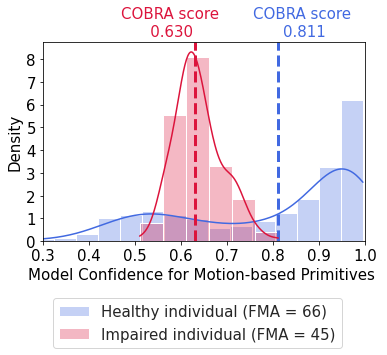

In [14]:
fig, axes = plt.subplots(1,1,figsize=(5.5,5.5))
sns.set(style='white')
# plt.hist(HC_df[HC_df['sub']==HC_sub[0]].motion_prob, alpha=0.4, density=True, color = 'deepskyblue', label='Healthy individual')
# plt.hist(HAR_df[HAR_df['sub']==HAR_sub[0]].motion_prob, alpha=0.4, density=True, color = 'salmon', label='Impaired individual')
# sns.histplot(X, kde=True, bins=20)

mhealthy = healthy_df[healthy_df['sub']=='C30'].mean_motion_seq_prob.mean()
plt.axvline(x = mhealthy, linestyle='--', linewidth=3, color = 'royalblue',label = '')

x = healthy_df.groupby('sub').agg({'prob_cal_1':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_2':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_4':lambda x: list(np.hstack(x.values)),
                                 }).reset_index()
y = x[x['sub']=='C30'][['prob_cal_1','prob_cal_2','prob_cal_4']].values
y = np.hstack(y.flatten())
y = np.random.choice(y, size=500)
sns.histplot(y, bins=15, alpha=0.3, kde=True, stat='density',color = 'royalblue', 
             label='Healthy individual (FMA = 66)')

print(plt.gca().get_ylim()[1]+0.3)


m = df[df['sub']=='s31'].mean_motion_seq_prob.mean()
plt.axvline(x = m,  linestyle='--', linewidth=3, color = 'crimson',  label = '')
sns.histplot(df[df['sub']=='s48'].mean_motion_seq_prob, bins=6, alpha=0.3, kde=True, stat='density',color = 'crimson', 
             label='Impaired individual (FMA = 45)')
print(plt.gca().get_ylim()[1]+0.3)
plt.annotate('COBRA score\n    {:.3f}   '.format(mhealthy), xy=(mhealthy+0.05, plt.gca().get_ylim()[1]+0.3),#xytext=(m,11),
             #arrowprops={"width":3,"headwidth":10,'headlength':10, "color":'deepskyblue',},
             horizontalalignment='center',color = 'royalblue', fontsize=15, annotation_clip=False)

plt.annotate('COBRA score \n   {:.3f}   '.format(m), xy=(m-0.05, plt.gca().get_ylim()[1]+0.3),#xytext=(0.4,1.5),
             #arrowprops={"width":3,"headwidth":10,'headlength':10, "color":'tomato',},
             horizontalalignment='center',color = 'crimson', fontsize=15, annotation_clip=False)

plt.xlim(0.3,1)
# plt.ylim(0, 6.3)
plt.ylabel('Density',fontsize=15)
plt.xlabel('Model Confidence for Motion-based Primitives ',fontsize=15)

plt.legend(fontsize=15,bbox_to_anchor=(0.95,-0.25))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
# plt.savefig('plot/sensor_individual_hist.pdf')
# plt.savefig('plot/sensor_individual_hist.png', dpi=300)



# Correlation between the COBRA score and clinical assessment

We first compare COBRA against Fugl-Meyer assessment (FMA) on a test cohort consisting of the remaining 4 healthy individuals and 51 stroke patients. 

Note that healthy individuals have a corresponding FMA=66

###  The COBRA score exploits clinically-relevant structure - Confidence in motion related primitives

Correlation coefficient = 0.814 
 (95% C.I. [0.700,0.888])


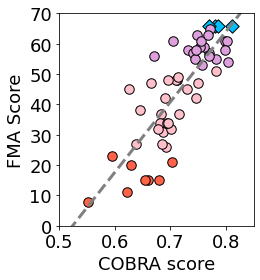

In [5]:
HC_confidence_by_sub = healthy_df.groupby('sub').mean()
HC_confidence_by_sub.reset_index(inplace=True, drop=False)

prob = df.groupby('sub').agg({'mean_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_non_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                 })
    
prob.reset_index(drop=False,inplace=True)
    
final = pd.merge(prob,fm_score[['sub','FM Score','Severity']],on='sub')    
final['motion'] = final.mean_motion_seq_prob.map(lambda x:np.nanmean(x))
final['all'] = final.mean_seq_prob.map(lambda x:np.nanmean(x))
final['non_motion'] = final.mean_non_motion_seq_prob.map(lambda x:np.nanmean(x))

COBRA_result = {}
COBRA_result['Combined'] = {}
COBRA_result['Combined']['stroke_n_unique_records'] = df.shape[0]
COBRA_result['Combined']['stroke_n_unique_subjects'] = prob.shape[0]

    
color_dict = {'healthy': 'lightskyblue', 'moderate':'pink',  'mild': 'plum','severe':'tomato'}
color = final.Severity.map(color_dict)
# sns.set(style='white')
fig, axes = plt.subplots(1,1,figsize=(4,4))
plt.rcParams['font.family'] = 'Helvetica'
plt.scatter(HC_confidence_by_sub.mean_motion_seq_prob, [66]*4, marker='D',edgecolor='black', color='deepskyblue',s=90, label='healthy(held-out)')
plt.scatter(final[final['Severity']=='mild']['motion'], final[final['Severity']=='mild']['FM Score'], edgecolor='black', color='plum',s=90,label='mild')
plt.scatter(final[final['Severity']=='moderate']['motion'], final[final['Severity']=='moderate']['FM Score'], edgecolor='black', color='pink',s=90,label='moderate')
plt.scatter(final[final['Severity']=='severe']['motion'], final[final['Severity']=='severe']['FM Score'], edgecolor='black', color='tomato',s=90,label='severe')
plt.xlim(0.5,0.85)
plt.ylim(0,70)
    
y = np.concatenate((final['motion'].values, HC_confidence_by_sub.mean_motion_seq_prob.values)) 
x = np.concatenate((final['FM Score'].values, np.array([66]*4)))
r, p, lo, hi = pearsonr_ci(y,x)

slope, intercept, r_value, p_value, std_err = stats.linregress(y,x)
    
plot_x = np.linspace(0.5,0.9, num=5)
line = [slope*ii for ii in plot_x] + intercept
plt.plot(plot_x, line, '--', color='grey',linewidth=3,)
                                             
    
print("Correlation coefficient = {:.3f} \n (95% C.I. [{:.3f},{:.3f}])".format(r, lo,hi))
COBRA_result['Combined']['stroke_motion_correlation'] = r
COBRA_result['Combined']['stroke_motion_correlation_low'] = lo
COBRA_result['Combined']['stroke_motion_correlation_high'] = hi

plt.xlabel('COBRA score',fontsize=18)
plt.ylabel('FMA Score',fontsize=18)
  
#plt.legend(fontsize=15,loc=4)#bbox_to_anchor=(1,0.5))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
# plt.savefig('plot/sensor_motion.pdf')
# plt.savefig('plot/sensor_motion.png', dpi=300)

    

###  The COBRA score exploits clinically-relevant structure - Confidence in non-motion related primitives

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


Correlation coefficient = 0.272 
 (95% C.I. [0.008,0.501])


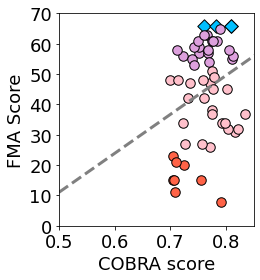

In [6]:
# sns.set(style='white')
fig, axes = plt.subplots(1,1,figsize=(4, 4))
plt.rcParams['font.family'] = 'Helvetica'
plt.scatter(HC_confidence_by_sub.mean_non_motion_seq_prob, [66]*4, marker='D',edgecolor='black', color='deepskyblue',s=90, label='healthy(held-out)')
plt.scatter(final[final['Severity']=='mild']['non_motion'], final[final['Severity']=='mild']['FM Score'], edgecolor='black', color='plum',s=90,label='mild')
plt.scatter(final[final['Severity']=='moderate']['non_motion'], final[final['Severity']=='moderate']['FM Score'], edgecolor='black', color='pink',s=90,label='moderate')
plt.scatter(final[final['Severity']=='severe']['non_motion'], final[final['Severity']=='severe']['FM Score'], edgecolor='black', color='tomato',s=90,label='severe')
plt.xlim(0.5,0.85)
plt.ylim(0,70)
y = np.concatenate((final['non_motion'].values, HC_confidence_by_sub.mean_non_motion_seq_prob.values)) 
x = np.concatenate((final['FM Score'].values, np.array([66]*4)))
r, p, lo, hi = pearsonr_ci(y,x)
slope, intercept, r_value, p_value, std_err = stats.linregress(y,x)
    
x = np.linspace(0.5,0.9, num=5)
line = [slope*ii for ii in x] + intercept
plt.plot(x, line, '--', color='grey',linewidth=3,)
                                        
print("Correlation coefficient = {:.3f} \n (95% C.I. [{:.3f},{:.3f}])".format(r, lo, hi))
plt.xlabel('COBRA score',fontsize=18)
plt.ylabel('FMA Score',fontsize=18)
  
#plt.legend(fontsize=15,loc=4)#bbox_to_anchor=(1,0.5))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()


###  The COBRA score exploits clinically-relevant structure - Confidence in all primitives

Correlation coefficient = 0.680 
 (95% C.I. [0.506,0.801])


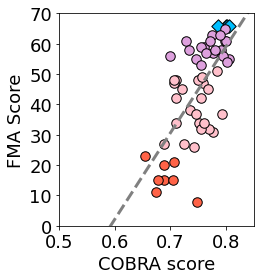

In [7]:
#sns.set(style='white')
fig, axes = plt.subplots(1,1,figsize=(4,4))
plt.rcParams['font.family'] = 'Helvetica'
plt.scatter(HC_confidence_by_sub.mean_seq_prob, [66]*4, marker='D',edgecolor='black', color='deepskyblue',s=90, label='healthy(held-out)')
plt.scatter(final[final['Severity']=='mild']['all'], final[final['Severity']=='mild']['FM Score'], edgecolor='black', color='plum',s=90,label='mild')
plt.scatter(final[final['Severity']=='moderate']['all'], final[final['Severity']=='moderate']['FM Score'], edgecolor='black', color='pink',s=90,label='moderate')
plt.scatter(final[final['Severity']=='severe']['all'], final[final['Severity']=='severe']['FM Score'], edgecolor='black', color='tomato',s=90,label='severe')
plt.xlim(0.5,0.85)
plt.ylim(0,70)

y = np.concatenate((final['all'].values, HC_confidence_by_sub.mean_seq_prob.values)) 
x = np.concatenate((final['FM Score'].values, np.array([66]*4)))
r, p, lo, hi = pearsonr_ci(y,x)
slope, intercept, r_value, p_value, std_err = stats.linregress(y,x)
    
x = np.linspace(0.5,0.9, num=5)
line = [slope*ii for ii in x] + intercept
plt.plot(x, line, '--', color='grey',linewidth=3,)
                                             
print("Correlation coefficient = {:.3f} \n (95% C.I. [{:.3f},{:.3f}])".format(r, lo,hi))
plt.xlabel('COBRA score',fontsize=18)
plt.ylabel('FMA Score',fontsize=18)
  
#plt.legend(fontsize=15,loc=4)#bbox_to_anchor=(1,0.5))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
# plt.savefig('plot/sensor_all.pdf')

    

# COBRA score in single activity

In [8]:
acts = ['brushing','combing','deodorant','drinking','facewash','feeding','glasses','shelf','RTT']
acts_display_name = {'brushing':'Brushing','combing':'Combing','deodorant':'Deodorant',
                     'drinking':'Drinking','facewash':'Face-wash','feeding':'Feeding',
                     'glasses':'Glasses','shelf':'Shelf','RTT':'Table-top'}


brushing
Correlation coefficient = 0.409 
 (95% C.I. [0.158,0.610])
combing
Correlation coefficient = 0.599 
 (95% C.I. [0.396,0.745])
deodorant
Correlation coefficient = 0.683 
 (95% C.I. [0.510,0.803])
drinking
Correlation coefficient = 0.600 
 (95% C.I. [0.398,0.746])
facewash
Correlation coefficient = 0.397 
 (95% C.I. [0.142,0.602])
feeding
Correlation coefficient = 0.585 
 (95% C.I. [0.376,0.737])
glasses
Correlation coefficient = 0.745 
 (95% C.I. [0.596,0.844])
shelf
Correlation coefficient = 0.752 
 (95% C.I. [0.605,0.850])
RTT
Correlation coefficient = 0.849 
 (95% C.I. [0.752,0.910])


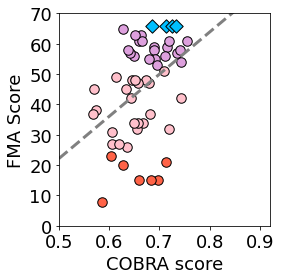

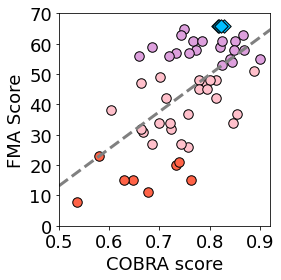

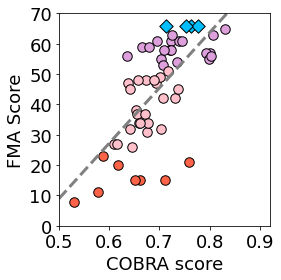

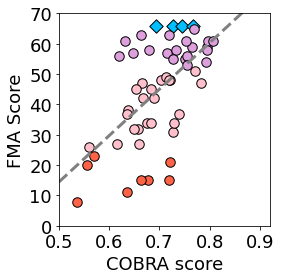

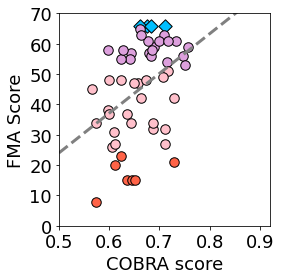

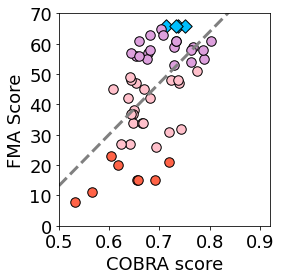

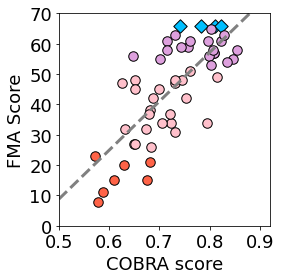

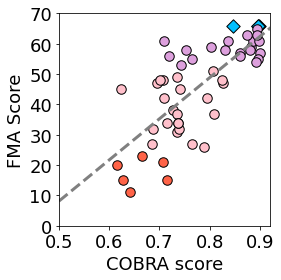

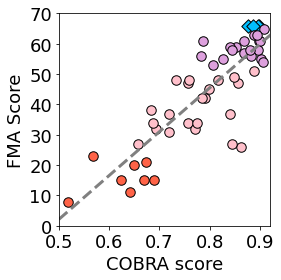

In [9]:
for i,a in enumerate(acts):
    HC_confidence_by_sub = healthy_df[healthy_df['act']==a].groupby('sub').mean()
    HC_confidence_by_sub.reset_index(inplace=True, drop=False)

    
    prob = df[df['act']==a].groupby('sub').agg({'mean_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_non_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                 })
    
    prob.reset_index(drop=False,inplace=True)
    final = pd.merge(prob,fm_score[['sub','FM Score','Severity']],on='sub')    
    final['motion'] = final.mean_motion_seq_prob.map(lambda x:np.nanmean(x))
    final['all'] = final.mean_seq_prob.map(lambda x:np.nanmean(x))
    final['non_motion'] = final.mean_non_motion_seq_prob.map(lambda x:np.nanmean(x))
    
    COBRA_result[acts_display_name[a]] = {}
    COBRA_result[acts_display_name[a]]['stroke_n_unique_records'] = df[df['act']==a].shape[0]
    COBRA_result[acts_display_name[a]]['stroke_n_unique_subjects'] = prob.shape[0]

    fig, axes = plt.subplots(1,1,figsize=(4,4))
    plt.rcParams['font.family'] = 'Helvetica'
    plt.scatter(HC_confidence_by_sub.mean_motion_seq_prob, [66]*4, marker='D',edgecolor='black', color='deepskyblue',s=90, label='healthy(held-out)')
    plt.scatter(final[final['Severity']=='mild']['motion'], final[final['Severity']=='mild']['FM Score'], edgecolor='black', color='plum',s=90,label='mild')
    plt.scatter(final[final['Severity']=='moderate']['motion'], final[final['Severity']=='moderate']['FM Score'], edgecolor='black', color='pink',s=90,label='moderate')
    plt.scatter(final[final['Severity']=='severe']['motion'], final[final['Severity']=='severe']['FM Score'], edgecolor='black', color='tomato',s=90,label='severe')
    plt.xlim(0.5,0.92)
    plt.ylim(0,70)
    y = np.concatenate((final['motion'].values, HC_confidence_by_sub.mean_motion_seq_prob.values)) 
    x = np.concatenate((final['FM Score'].values, np.array([66]*4)))
    r, p, lo, hi = pearsonr_ci(y,x)
    COBRA_result[acts_display_name[a]]['stroke_motion_correlation'] = r
    COBRA_result[acts_display_name[a]]['stroke_motion_correlation_low'] = lo
    COBRA_result[acts_display_name[a]]['stroke_motion_correlation_high'] = hi

    slope, intercept, r_value, p_value, std_err = stats.linregress(y,x)
    
    x = np.linspace(0.5,0.95, num=5)
    line = [slope*ii for ii in x] + intercept
    plt.plot(x, line, '--', color='grey',linewidth=3,)
                                            
    print(a)
    print("Correlation coefficient = {:.3f} \n (95% C.I. [{:.3f},{:.3f}])".format(r, lo,hi))
    print('===========')
    plt.xlabel('COBRA score',fontsize=18)
    plt.ylabel('FMA Score',fontsize=18)

    #plt.legend(fontsize=15,loc=4)#bbox_to_anchor=(1,0.5))
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    #plt.savefig(f'plot/sensor_{a}_motion.pdf')
    

# Compare impairment quantification results from individual rehabilitation activities

In [10]:
combined_performance_df = pd.DataFrame(COBRA_result).T
combined_performance_df.sort_values(by='stroke_motion_correlation',inplace=True)

combined_performance_df.index


Index(['Face-wash', 'Brushing', 'Feeding', 'Combing', 'Drinking', 'Deodorant',
       'Glasses', 'Shelf', 'Combined', 'Table-top'],
      dtype='object')

In [11]:
combined_performance_df = combined_performance_df.loc[['Face-wash', 'Brushing', 'Feeding', 'Combing', 'Drinking', 'Deodorant',
       'Glasses', 'Shelf', 'Table-top', 'Combined']]

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


Text(0.5, 1.0, 'Wearable Sensors')

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


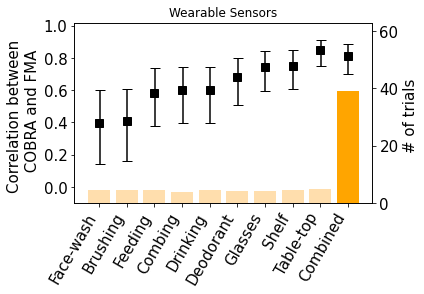

In [12]:
fig, ax1 = plt.subplots(figsize=(6,4))
ax2 = ax1.twinx()
X = combined_performance_df.index.tolist()
  
X_axis = np.arange(len(X))

ax1.plot(X_axis,combined_performance_df['stroke_motion_correlation'].values.tolist(),
         's',markersize=8,color='black',label='sensor')
err_low = combined_performance_df['stroke_motion_correlation'] - combined_performance_df['stroke_motion_correlation_low']
err_up = combined_performance_df['stroke_motion_correlation_high'] - combined_performance_df['stroke_motion_correlation']
err = np.array([err_low.values.tolist(), err_up.values.tolist()])
ax1.errorbar(X_axis + 0.02, combined_performance_df['stroke_motion_correlation'].values.tolist(),
             yerr=err, ls='none', color='black', capsize=5 )

num_trials = combined_performance_df.stroke_n_unique_records/combined_performance_df.stroke_n_unique_subjects/5
num_trials = num_trials.to_list()
ax2.bar(X_axis[:-1],num_trials[:-1],color = 'navajowhite')
ax2.bar(X_axis[-1],num_trials[-1], color = 'orange')

plt.xticks(X_axis.tolist() , X)
plt.xticks(rotation=90)
plt.ylim(0,63)
ax1.set_ylim(-0.1,1.02)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xticklabels(X, rotation = 60)

ax1.set_ylabel('Correlation between \n COBRA and FMA',fontsize=15)
ax2.set_ylabel('# of trials ',fontsize=15)
#plt.legend(fontsize=14)
plt.tight_layout()
plt.setp(ax1.xaxis.get_majorticklabels(), ha='right')
plt.title('Wearable Sensors')
# plt.savefig('data_efficiency_per_act_sensor.pdf')